# Cluster

## Objectives

* Fit and evaluate a cluster model to group similar data
* Understand the profile for each cluster


## Inputs

* outputs/datasets/collection/house_prices_records.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in their respective notebooks.

## Outputs

* Cluster Pipeline
* Train Set
* Most important features to define a cluster plot
* Clusters Profile Description
* Cluster Silhouette


---

# Change working directory

In [1]:
import os 

project_root = "/workspaces/milestone-project-heritage-housing-issues"
os.chdir(project_root)

print("Current working directory set to:")
print(os.getcwd())

Current working directory set to:
/workspaces/milestone-project-heritage-housing-issues


---

# Load Data

In [2]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/cleaned/house_prices_cleaned.csv")
      .drop(labels=['EnclosedPorch', 'WoodDeckSF'], axis=1)
      # variables we will not need for this project
      )

print(df.shape)
df.head(3)

(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500


In [3]:
n_components_possible = df.shape[1]
print(f"Maximum possible components before PCA: {n_components_possible}")


Maximum possible components before PCA: 22


# Cluster Pipeline with all data

##  ML Cluster Pipeline

In [4]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# PCA
from sklearn.decomposition import PCA

# ML algorithm
from sklearn.cluster import KMeans


def PipelineCluster():
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman",
                                                              threshold=0.6, selection_method="variance")),

        ("scaler", StandardScaler()),

        ("PCA", PCA(n_components=10, random_state=0)), #or 95% explained variance

        ("model", KMeans(n_clusters=5, random_state=0)),


    ])
    return pipeline_base


## Principal Component Analysis (PCA)

In [5]:
pipeline_cluster = PipelineCluster()
pipeline_pca = Pipeline(pipeline_cluster.steps[:-2])
df_pca = pipeline_pca.fit_transform(df)

print(df_pca.shape,'\n', type(df_pca))

(1460, 17) 
 <class 'numpy.ndarray'>


Apply PCA separately to the scaled data

* The 10 components explain 85.21% of the data 



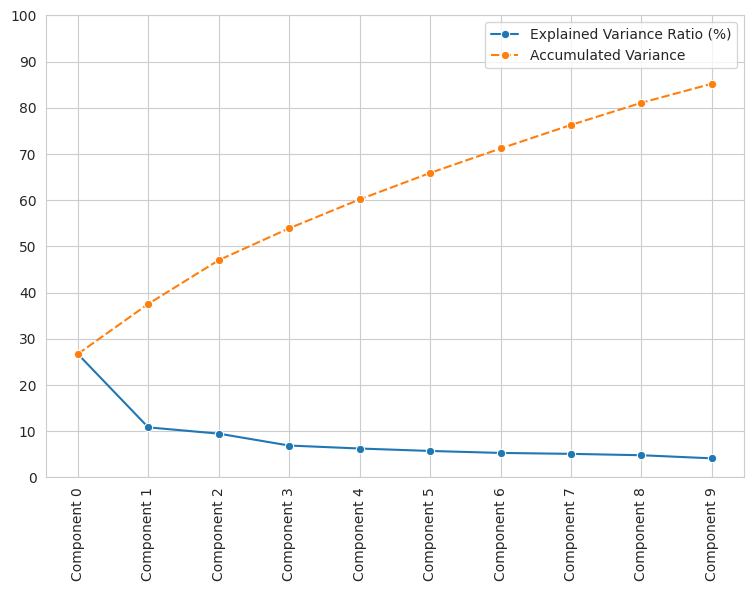

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

n_components = 10


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)


A common guideline is to aim for retaining 90-95% of the variance. Therefore we will increase the n_components: 11.

* The 11 components explain 89.06% of the data 



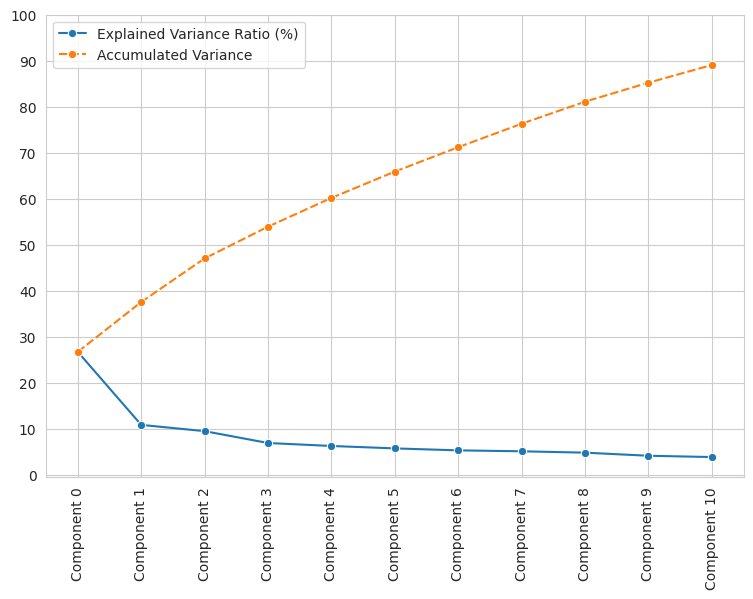

In [7]:
pca_components_analysis(df_pca=df_pca,n_components=11)

In [10]:
def PipelineCluster():
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman",
                                                              threshold=0.6, selection_method="variance")),

        ("scaler", StandardScaler()),

        # we update n_components to 6
        ("PCA", PCA(n_components=11, random_state=0)),

        ("model", KMeans(n_clusters=5, random_state=0)),


    ])
    return pipeline_base


PipelineCluster()


Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_components=11, random_state=0)),
                ('model', KMeans(n_clusters=5, random_state=0))])

## Elbow Method and Silhouette Score

In [11]:
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df)

print(df_analysis.shape,'\n', type(df_analysis))

(1460, 11) 
 <class 'numpy.ndarray'>


/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 1

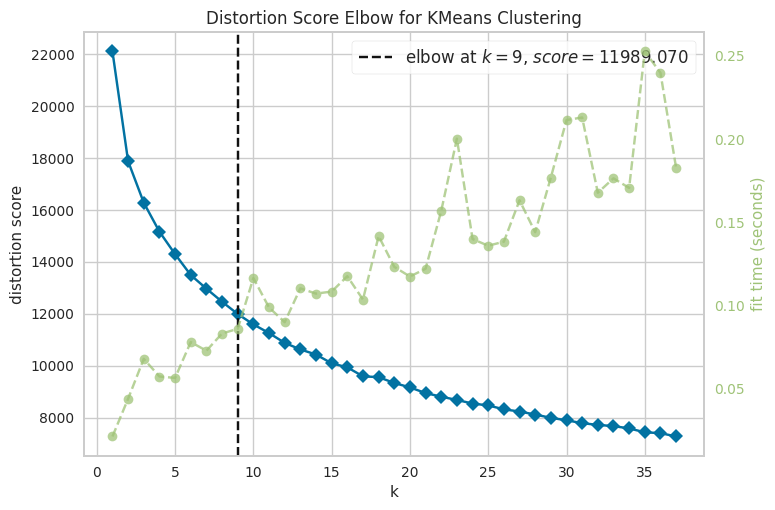

In [13]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,38)) # kmax​≈n​=1460​≈38
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()

=== Average Silhouette Score for different number of clusters ===


/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 1

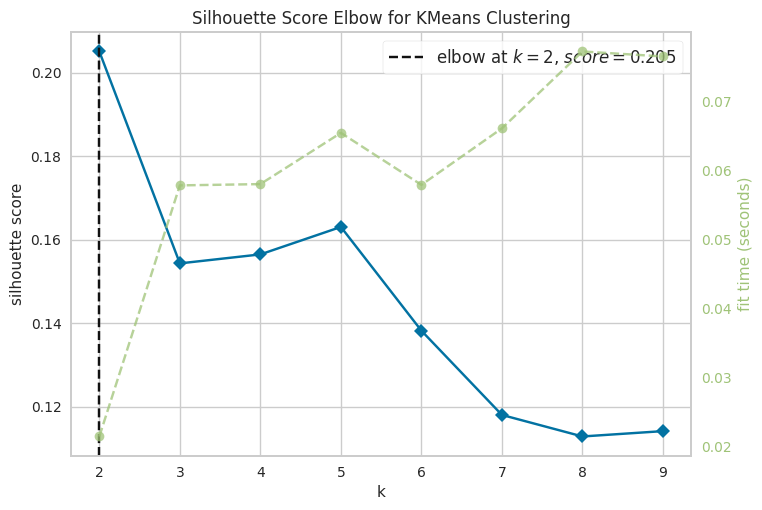

/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)




=== Silhouette plot for 2 Clusters ===


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

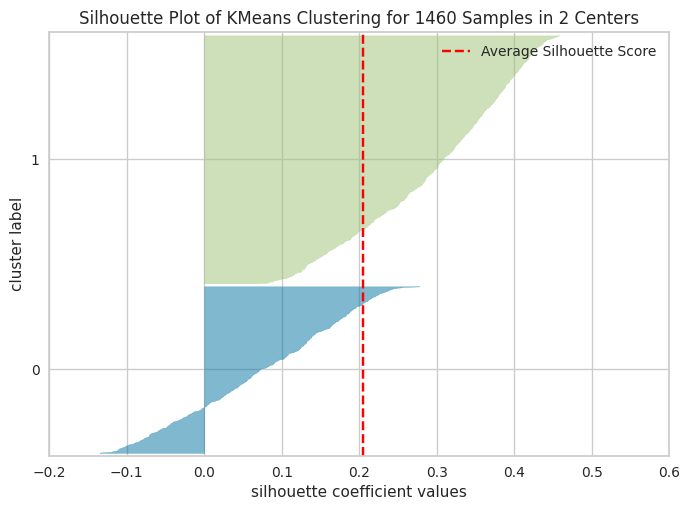

/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)




=== Silhouette plot for 3 Clusters ===


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

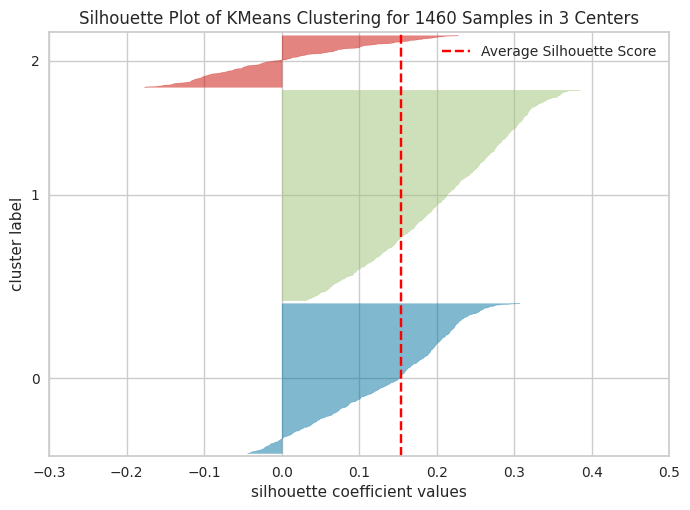

/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)




=== Silhouette plot for 4 Clusters ===


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

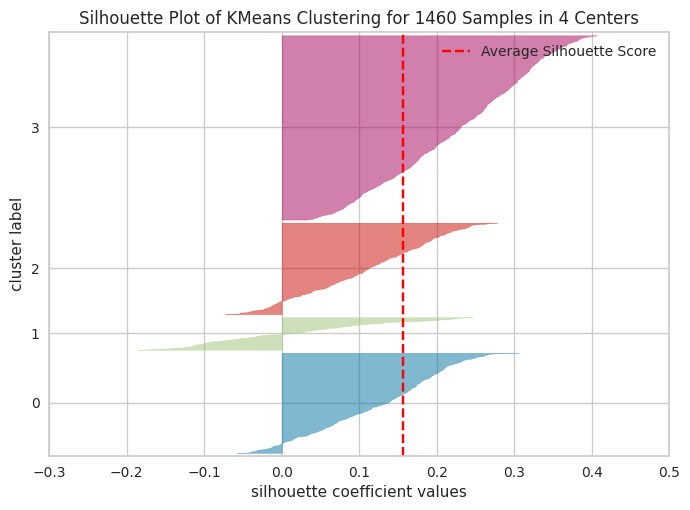

/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)




=== Silhouette plot for 5 Clusters ===


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

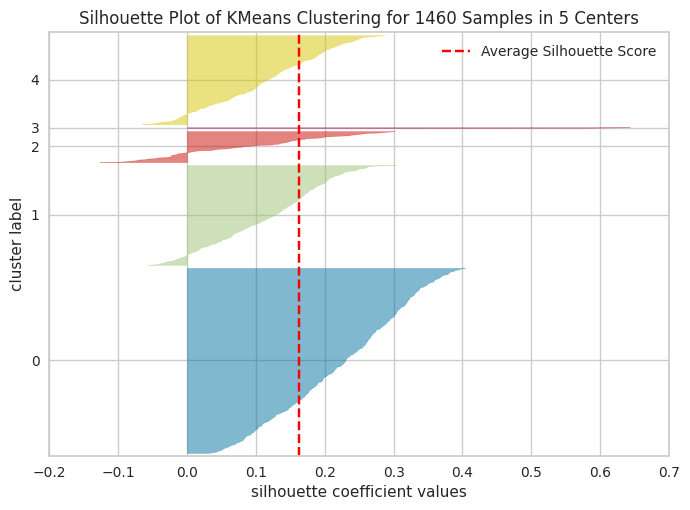

/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)




=== Silhouette plot for 6 Clusters ===


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

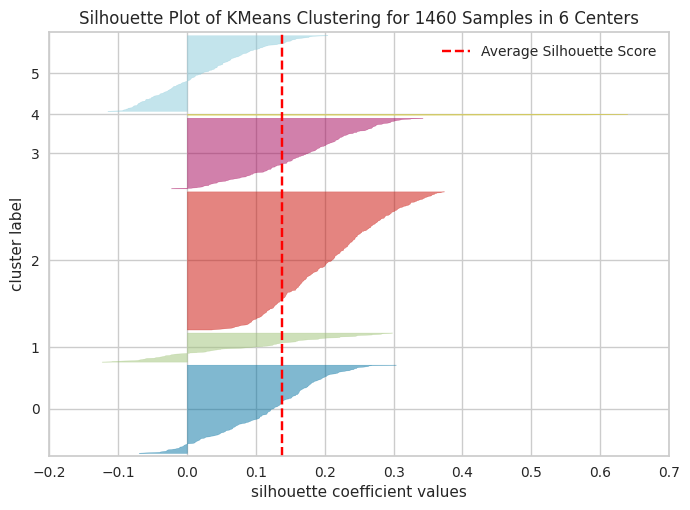

/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)




=== Silhouette plot for 7 Clusters ===


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

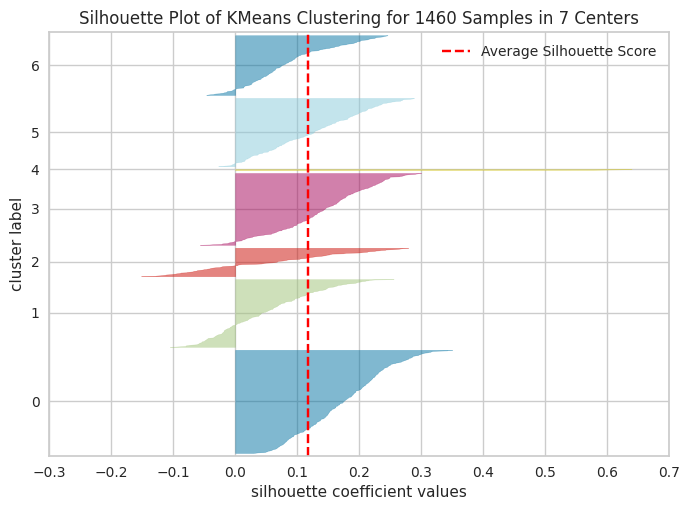

/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)




=== Silhouette plot for 8 Clusters ===


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

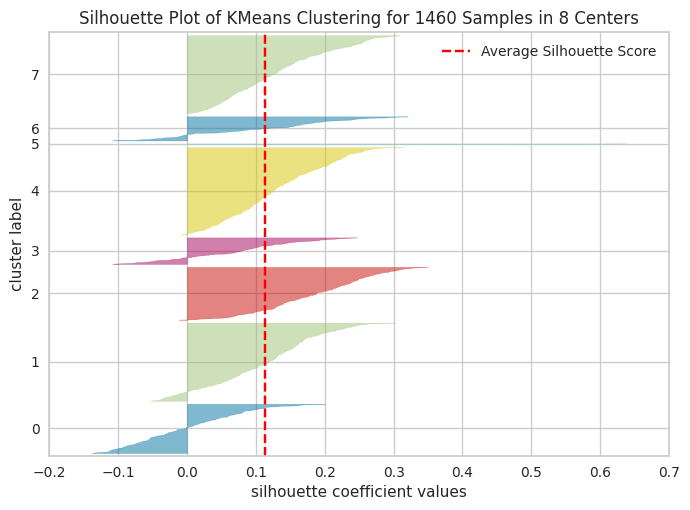

/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)




=== Silhouette plot for 9 Clusters ===


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

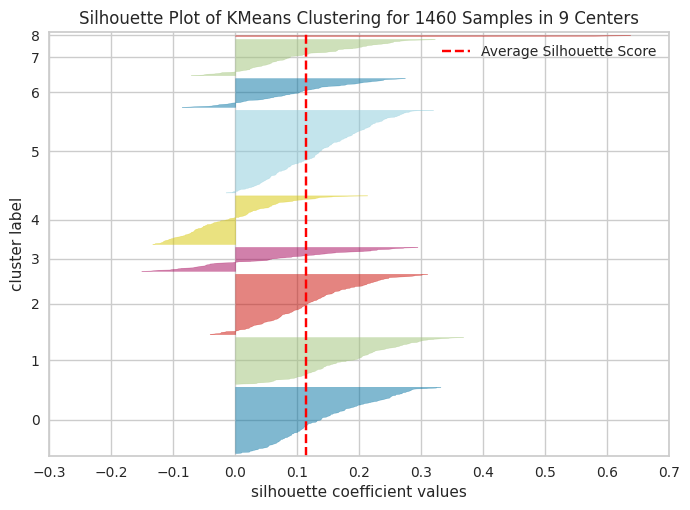

In [14]:
from yellowbrick.cluster import SilhouetteVisualizer

n_cluster_start, n_cluster_stop = 2, 10

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(
    n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters, random_state=0),
                                      colors='yellowbrick')
    visualizer.fit(df_analysis)
    visualizer.show()
    plt.show()
    print("\n")


In [18]:
from sklearn.cluster import KMeans
import pandas as pd

# List of k values you want to test
k_values = [2, 3, 4, 5, 6, 7, 8, 9]

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(df_analysis)
    
    cluster_sizes = pd.Series(labels).value_counts().sort_index()
    print(f"\nNumber of clusters: {k}")
    print("Cluster sizes:")
    print(cluster_sizes)

/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Number of clusters: 2
Cluster sizes:
0    587
1    873
Name: count, dtype: int64

Number of clusters: 3
Cluster sizes:
0    531
1    746
2    183
Name: count, dtype: int64

Number of clusters: 4
Cluster sizes:
0    358
1    117
2    327
3    658
Name: count, dtype: int64

Number of clusters: 5
Cluster sizes:
0    665
1    359
2    112
3      4
4    320
Name: count, dtype: int64


/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Number of clusters: 6
Cluster sizes:
0    320
1    106
2    500
3    256
4      4
5    274
Name: count, dtype: int64

Number of clusters: 7
Cluster sizes:
0    376
1    247
2    104
3    262
4      4
5    249
6    218
Name: count, dtype: int64


/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Number of clusters: 8
Cluster sizes:
0    181
1    287
2    194
3     98
4    320
5      4
6     89
7    287
Name: count, dtype: int64

Number of clusters: 9
Cluster sizes:
0    245
1    173
2    223
3     89
4    180
5    305
6    107
7    134
8      4
Name: count, dtype: int64


/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [22]:
def PipelineCluster():
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman",
                                                              threshold=0.6, selection_method="variance")),

        ("scaler", StandardScaler()),

        ("PCA", PCA(n_components=11, random_state=0)),

        # we update n_clusters to 3
        ("model", KMeans(n_clusters=3, random_state=0)),


    ])
    return pipeline_base


PipelineCluster()


Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_components=11, random_state=0)),
                ('model', KMeans(n_clusters=3, random_state=0))])

## Fit Cluster Pipeline

Quick recap of our data for training cluster pipeline

In [23]:
X = df.copy()
print(X.shape)
X.head(3)

(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500


Fit Cluster pipeline

In [24]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)

/home/cistudent/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_components=11, random_state=0)),
                ('model', KMeans(n_clusters=3, random_state=0))])

## Add cluster predictions to dataset

We add a column "`Clusters`" (with the cluster pipeline predictions) to the dataset

In [25]:
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head(3)

(1460, 23)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice,Clusters
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,65.0,196.0,61,5,7,856,2003,2003,208500,0
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,80.0,0.0,0,8,6,1262,1976,1976,181500,1
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,68.0,162.0,42,5,7,920,2001,2002,223500,0


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

* Clusters frequencies 
          proportion
Clusters            
1               0.51
0               0.36
2               0.13 




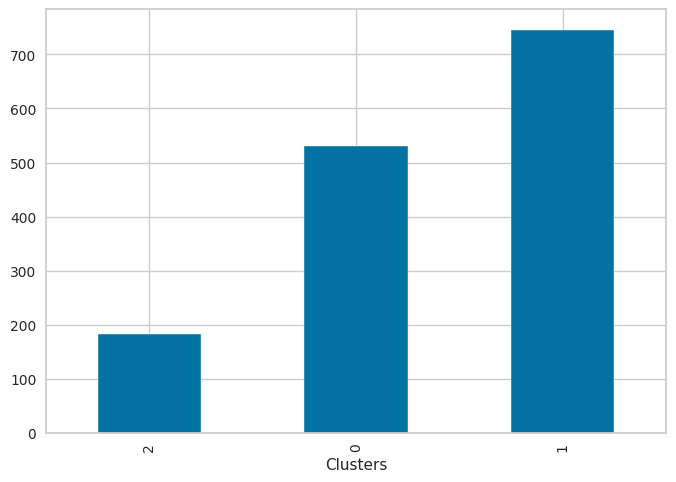

In [26]:
print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

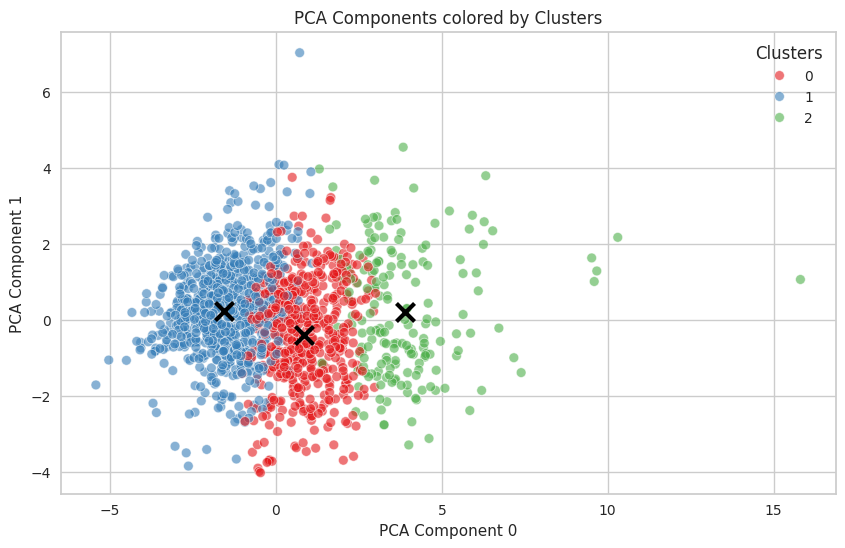

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_analysis[:, 0], y=df_analysis[:, 1],
                hue=X['Clusters'], palette='Set1', alpha=0.6)
plt.scatter(x=pipeline_cluster['model'].cluster_centers_[:, 0], y=pipeline_cluster['model'].cluster_centers_[:, 1],
            marker="x", s=169, linewidths=3, color="black")
plt.xlabel("PCA Component 0")
plt.ylabel("PCA Component 1")
plt.title("PCA Components colored by Clusters")
plt.show()


We save the cluster predictions from this pipeline to use in the future. We will get back to that in a later stage.

In [28]:
cluster_predictions_with_all_variables = X['Clusters']
cluster_predictions_with_all_variables

0       0
1       1
2       0
3       1
4       2
       ..
1455    0
1456    0
1457    0
1458    1
1459    1
Name: Clusters, Length: 1460, dtype: int32

## Fit a classifier, where the target is cluster predictions and features remaining variables

We copy `X` to a DataFrame `df_clf`

In [29]:
df_clf = X.copy()
print(df_clf.shape)
df_clf.head(3)

(1460, 23)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice,Clusters
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,65.0,196.0,61,5,7,856,2003,2003,208500,0
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,80.0,0.0,0,8,6,1262,1976,1976,181500,1
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,68.0,162.0,42,5,7,920,2001,2002,223500,0


Split Train and Test sets

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['Clusters'], axis=1),
    df_clf['Clusters'],
    test_size=0.2,
    random_state=0
)

print(X_train.shape, X_test.shape)


(1168, 22) (292, 22)


Create classifier pipeline steps

In [37]:
# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithm
from sklearn.ensemble import ExtraTreesRegressor


def PipelineClf2ExplainClusters():
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman",
                                                              threshold=0.6, selection_method="variance")),

        ("scaler", StandardScaler()),

        ("feat_selection", SelectFromModel(
            ExtraTreesRegressor(random_state=0))),

        ("model", ExtraTreesRegressor(random_state=0)),

    ])
    return pipeline_base


PipelineClf2ExplainClusters()


Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model', ExtraTreesRegressor(random_state=0))])

Fit the classifier to the training data

In [38]:
pipeline_clf_cluster = PipelineClf2ExplainClusters()
pipeline_clf_cluster.fit(X_train, y_train)

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model', ExtraTreesRegressor(random_state=0))])

## Evaluate classifier performance on Train and Test Sets

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Fit your pipeline first
pipeline_clf_cluster.fit(X_train, y_train)

# Predict on training set
y_pred_train = pipeline_clf_cluster.predict(X_train)

# Evaluate
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)

print(f"R² score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


R² score: 1.0000
RMSE: 0.00
MAE: 0.00


In [35]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Assuming you have a fitted scaler for y
# scaler_y = StandardScaler().fit(y_train.values.reshape(-1,1))
# And your pipeline predictions:
y_pred_scaled = pipeline_clf_cluster.predict(X_train)

# Inverse-transform predictions and true values
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_true = scaler_y.inverse_transform(y_train.values.reshape(-1, 1))

# Compute metrics in original SalePrice units
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f"R² score: {r2:.4f}")
print(f"RMSE: {rmse:,.0f} $")
print(f"MAE: {mae:,.0f} $")


NameError: name 'scaler_y' is not defined

## Assess the most important Features that define a cluster

In [ ]:
# after data cleaning and feature engineering, the feature space changes

# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf_cluster.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[pipeline_clf_cluster['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf_cluster['feat_selection'].get_support()],
    'Importance': pipeline_clf_cluster['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# reassign best features in importance order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features} \n")
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


We will store the best_features to use at a later stage.

In [ ]:
best_features_pipeline_all_variables = best_features
best_features_pipeline_all_variables

## Cluster Analysis

Load function that plots a table with description for all Clusters

In [ ]:

def DescriptionAllClusters(df, decimal_points=3):

    DescriptionAllClusters = pd.DataFrame(
        columns=df.drop(['Clusters'], axis=1).columns)
    # iterate on each cluster , calls Clusters_IndividualDescription()
    for cluster in df.sort_values(by='Clusters')['Clusters'].unique():

        EDA_ClusterSubset = df.query(
            f"Clusters == {cluster}").drop(['Clusters'], axis=1)
        ClusterDescription = Clusters_IndividualDescription(
            EDA_ClusterSubset, cluster, decimal_points)
        DescriptionAllClusters = pd.concat(
            [ClusterDescription, DescriptionAllClusters])

    DescriptionAllClusters.set_index(['Cluster'], inplace=True)
    return DescriptionAllClusters


def Clusters_IndividualDescription(EDA_Cluster, cluster, decimal_points):

    ClustersDescription = pd.DataFrame(columns=EDA_Cluster.columns)
    # for a given cluster, iterate over all columns
    # if the variable is numerical, calculate the IQR: display as Q1 -- Q3.
    # That will show the range for the most common values for the numerical variable
    # if the variable is categorical, count the frequencies and displays the top 3 most frequent
    # That will show the most common levels for the category

    for col in EDA_Cluster.columns:

        try:  # eventually a given cluster will have only missing data for a given variable

            if EDA_Cluster[col].dtypes == 'object':

                top_frequencies = EDA_Cluster.dropna(
                    subset=[col])[[col]].value_counts(normalize=True).nlargest(n=3)
                Description = ''

                for x in range(len(top_frequencies)):
                    freq = top_frequencies.iloc[x]
                    category = top_frequencies.index[x][0]
                    CategoryPercentage = int(round(freq*100, 0))
                    statement = f"'{category}': {CategoryPercentage}% , "
                    Description = Description + statement

                ClustersDescription.at[0, col] = Description[:-2]

            elif EDA_Cluster[col].dtypes in ['float', 'int']:
                DescStats = EDA_Cluster.dropna(subset=[col])[[col]].describe()
                Q1 = round(DescStats.iloc[4, 0], decimal_points)
                Q3 = round(DescStats.iloc[6, 0], decimal_points)
                Description = f"{Q1} -- {Q3}"
                ClustersDescription.at[0, col] = Description

        except Exception as e:
            ClustersDescription.at[0, col] = 'Not available'
            print(
                f"** Error Exception: {e} - cluster {cluster}, variable {col}")

    ClustersDescription['Cluster'] = str(cluster)

    return ClustersDescription


Load a custom function to plot cluster distribution per Variable (absolute and relative levels)

In [ ]:
import plotly.express as px


def cluster_distribution_per_variable(df, target):
    """
    The data should have 2 variables, the cluster predictions and
    the variable you want to analyze with, in this case we call "target".
    We use plotly express to create 2 plots:
    Cluster distribution across the target.
    Relative presence of the target level in each cluster.
    """
    df_bar_plot = df.groupby(['Clusters', target]).size().reset_index(name='Count')
    df_bar_plot.columns = ['Clusters', target, 'Count']
    df_bar_plot[target] = df_bar_plot[target].astype('object')

    print(f"Clusters distribution across {target} levels")
    fig = px.bar(df_bar_plot, x='Clusters', y='Count',
                 color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array',
                      tickvals=df['Clusters'].unique()))
    fig.show(renderer='jupyterlab')

    df_relative = (df
                   .groupby(["Clusters", target])
                   .size()
                   .unstack(fill_value=0)
                   .apply(lambda x: 100 * x / x.sum(), axis=1)
                   .stack()
                   .reset_index(name='Relative Percentage (%)')
                   .sort_values(by=['Clusters', target])
                   )

    print(f"Relative Percentage (%) of {target} in each cluster")
    fig = px.line(df_relative, x='Clusters', y='Relative Percentage (%)',
                  color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array',
                      tickvals=df['Clusters'].unique()))
    fig.update_traces(mode='markers+lines')
    fig.show(renderer='jupyterlab')



Create a DataFrame that contains best features and Clusters Predictions since we want to analyse the patterns for each cluster.


In [ ]:
df_cluster_profile = df_clf.copy()
df_cluster_profile = df_cluster_profile.filter(items=best_features + ['Clusters'], axis=1)
print(df_cluster_profile.shape)
df_cluster_profile.head(3)

We want also to analyse Churn levels.

In [ ]:
df_churn = pd.read_csv("outputs/datasets/collection/TelcoCustomerChurn.csv").filter(['Churn'])
df_churn['Churn'] = df_churn['Churn'].astype('object')
df_churn.head(3)

### Cluster profile based on the best features

In [ ]:
pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(df=pd.concat([df_cluster_profile,df_churn], axis=1), decimal_points=0)
clusters_profile

### Clusters distribution across Churn levels & Relative Percentage of Churn in each cluster

In [ ]:
df_cluster_vs_churn=  df_churn.copy()
df_cluster_vs_churn['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster_vs_churn, target='Churn')

# Fit New Cluster Pipeline with most important features

In order to reduce feature space, we will study the trade-off between the previous Cluster Pipeline (fitted with all variables) and Pipeline using the variables that are most important to define the clusters from the previous pipeline

In [ ]:
best_features_pipeline_all_variables

## Define trade-off and metrics to compare new and previous Cluster Pipeline

To evaluate this trade-off we will
1. Conduct a elbow method and silhouette analysis and check if the same number of clusters is suggested
2. Fit new cluster pipeline and compare if the predictions from this pipeline are "equivalent" to the predictions from the previous pipeline
3. Fit a classifier to explain cluster, and check if performance on Train and Test sets is similar to the previous pipeline
4. Check if the most important features for the classifier are the same from the previous pipeline
5. Compare if the cluster profile from both pipelines are "equivalent"

If we are happy to say **yes** for them, we can use a cluster pipeline using the features that best define the clusters from previous pipeline!
* The **gain** is that in real-time (which is the major purpose of Machine Learning) you will need fewer variables for predicting clusters for your prospects.

## Subset data with the most relevant variables

In [ ]:
df_reduced = df.filter(best_features_pipeline_all_variables)
df_reduced.head(3)

## Rewrite Cluster Pipeline

In [ ]:
def PipelineCluster():
    pipeline_base = Pipeline([

        # we update the pipeline, considering only the most important variables from the previous pipeline
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['OnlineBackup', 'PhoneService'])),

        # it doesn't need SmartCorrelation

        ("scaler", StandardScaler()),

        # No PCA step needed, since we know which features to consider

        ("model", KMeans(n_clusters=3, random_state=0)),


    ])
    return pipeline_base


PipelineCluster()


## Apply Elbow Method and Silhouette analysis

In [ ]:
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df_reduced)

print(df_analysis.shape,'\n', type(df_analysis))

Elbow Analysis

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,11))
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

n_cluster_start, n_cluster_stop = 2, 5

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(
    n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters, random_state=0),
                                      colors='yellowbrick')
    visualizer.fit(df_analysis)
    visualizer.show()
    plt.show()
    print("\n")


## Fit New Cluster Pipeline

We set X as our training set for the cluster. It is a copy of df_reduced

In [ ]:
X = df_reduced.copy()
print(X.shape)
X.head(3)

Fit Cluster pipeline

In [ ]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)

## Add cluster predictions to dataset

We add a column "`Clusters`" (with the cluster pipeline predictions) to the dataset

In [ ]:
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head(3)

In [ ]:
print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

## Compare current cluster predictions to previous cluster predictions

We just fitted a new cluster pipeline and want to compare if its predictions are "equivalent" to the previous cluster.

These are the predictions from the **previous** cluster pipeline - trained with all variables 

In [ ]:
cluster_predictions_with_all_variables

And these are the predictions from **current** cluster pipeline (trained with `['OnlineBackup', 'MonthlyCharges', 'PhoneService']`)

In [ ]:
cluster_predictions_with_best_features = X['Clusters'] 
cluster_predictions_with_best_features

We use a confusion matrix to evaluate if the predictions of both pipelines are **"equivalent"**

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(cluster_predictions_with_all_variables, cluster_predictions_with_best_features))

## Fit a classifier, where the target is cluster predictions and features remaining variables

In [ ]:
df_clf = X.copy()
print(df_clf.shape)
df_clf.head(3)

Split Train and Test sets

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['Clusters'], axis=1),
    df_clf['Clusters'],
    test_size=0.2,
    random_state=0
)

print(X_train.shape, X_test.shape)


Rewrite pipeline to explain clusters

In [ ]:
def PipelineClf2ExplainClusters():
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['OnlineBackup', 'PhoneService'])),

        # it doesn't need SmartCorrelation

        ("scaler", StandardScaler()),

        # we don't consider feature selection step, since we know which features to consider

        ("model", GradientBoostingClassifier(random_state=0)),

    ])
    return pipeline_base


PipelineClf2ExplainClusters()


## Fit a classifier, where the target is cluster labels and features remaining variables

Create and fit a classifier pipeline to learn the feature importance when defining a cluster

In [ ]:
pipeline_clf_cluster = PipelineClf2ExplainClusters()
pipeline_clf_cluster.fit(X_train,y_train)

## Evaluate classifier performance on Train and Test Sets

In [ ]:
print(classification_report(y_train, pipeline_clf_cluster.predict(X_train)))

In [ ]:
print(classification_report(y_test, pipeline_clf_cluster.predict(X_test)))

## Assess Most Important Features

In [ ]:
# since we don't have feature selection step in this pipeline, best_features is Xtrain columns
best_features = X_train.columns.to_list()

# create a DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_clf_cluster['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Cluster Analysis

Create a DataFrame that contains the best features and Clusters Predictions: we want to analyse the patterns for each cluster.


In [ ]:
df_cluster_profile = df_clf.copy()
df_cluster_profile = df_cluster_profile.filter(items=best_features + ['Clusters'], axis=1)
df_cluster_profile.head(3)

We want also to analyse Churn levels

In [ ]:
df_churn = pd.read_csv("outputs/datasets/collection/TelcoCustomerChurn.csv").filter(['Churn'])
df_churn['Churn'] = df_churn['Churn'].astype('object')
df_churn.head(3)

### Cluster profile on most important features

In [ ]:
pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(df= pd.concat([df_cluster_profile,df_churn], axis=1), decimal_points=0)
clusters_profile

### Clusters distribution across Churn levels & Relative Percentage of Churn in each cluster

In [ ]:
df_cluster_vs_churn=  df_churn.copy()
df_cluster_vs_churn['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster_vs_churn, target='Churn')

## Which pipeline should I deploy?

Let's recap the criteria we consider to evaluate the **trade-off**
1. Conduct an elbow method and silhouette analysis and check if the same number of clusters is suggested.
2. Fit a new cluster pipeline and compare if the predictions from this pipeline are "equivalent" to the predictions from the previous pipeline.
3. Fit a classifier to explain cluster and check if performance on Train and Test sets is similar to the previous pipeline.
4. Check if the most important features for the classifier are the same from the previous pipeline.
5. Compare if the cluster profile from both pipelines is "equivalent".


In [ ]:
pipeline_cluster

# Push files to Repo


We will generate the following files

* Cluster Pipeline
* Train Set
* Feature importance plot
* Clusters Description
* Cluster Silhouette


In [ ]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/cluster_analysis/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)


## Cluster pipeline

In [ ]:
pipeline_cluster

In [ ]:
joblib.dump(value=pipeline_cluster, filename=f"{file_path}/cluster_pipeline.pkl")

## Train Set

In [ ]:
print(df_reduced.shape)
df_reduced.head(3)

In [ ]:
df_reduced.to_csv(f"{file_path}/TrainSet.csv", index=False)

## Most important features plot

These are the features that define a cluster

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance', figsize=(8,4))
plt.show()

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance', figsize=(8,4))
plt.savefig(f"{file_path}/features_define_cluster.png", bbox_inches='tight', dpi=150)

## Cluster Profile

In [ ]:
clusters_profile

In [ ]:
clusters_profile.to_csv(f"{file_path}/clusters_profile.csv")

## Cluster silhouette plot

In [ ]:
visualizer = SilhouetteVisualizer(Pipeline(pipeline_cluster.steps[-1:])[0] , colors='yellowbrick')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()

In [ ]:
fig, axes = plt.subplots(figsize=(7,5))
fig = SilhouetteVisualizer(Pipeline(pipeline_cluster.steps[-1:])[0] , colors='yellowbrick', ax=axes)
fig.fit(df_analysis)

plt.savefig(f"{file_path}/clusters_silhouette.png", bbox_inches='tight',dpi=150)

Good job, clear the cell outputs, run git commands to add, commit and push files to the repo. Next, we will move on to create our dashboard!